# 04 Modeling

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, PrecisionRecallDisplay
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [2]:
df = pd.read_csv('../data/processed/merged_data.csv')
df['Weight (lbs)'] = df['Weight (lbs)'].replace('-', np.nan)
train_df = df.query("`Draft Year` <= 2019") # Filter out the new/undeveloped players

In [22]:
X = train_df.drop('All-Star', axis=1)
y = train_df['All-Star'].map({'Yes': 1, 'No': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47, stratify=y)
train_names = X_train['Player']
test_names = X_test['Player']
X_train = X_train.drop(['Player', 'Draft Year', 'Team'], axis=1) # Get rid of qualitative columns
X_test = X_test.drop(['Player', 'Draft Year', 'Team'], axis=1)

In [5]:
model = RandomForestClassifier(random_state=47)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
print (accuracy_score(y_test, predicted))

0.9301470588235294


Since there is a class imbalance, accuracy doesn't mean much because classifying every player as 'No' for all-star status would lead to an accuracy like this

### Performance metrics

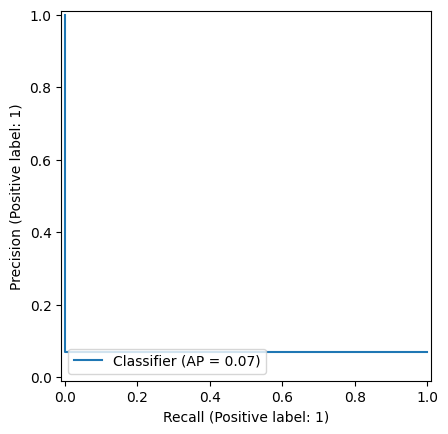

In [6]:
PrecisionRecallDisplay.from_predictions(y_test, predicted)

In [7]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       253
           1       0.00      0.00      0.00        19

    accuracy                           0.93       272
   macro avg       0.47      0.50      0.48       272
weighted avg       0.87      0.93      0.90       272



/Users/jackkenzakowski/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jackkenzakowski/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jackkenzakowski/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [8]:
print(confusion_matrix(y_test, predicted))

[[253   0]
 [ 19   0]]


As we can see, the results are pretty abysmal. As feared, none of the players were classified as All-Stars and that is what contributed to the accuracy of 0.93

## Model Adjustments

In [9]:
model = RandomForestClassifier(class_weight='balanced_subsample', random_state=47)

model.fit(X_train, y_train)
 
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       253
           1       0.00      0.00      0.00        19

    accuracy                           0.93       272
   macro avg       0.47      0.50      0.48       272
weighted avg       0.87      0.93      0.90       272

[[253   0]
 [ 19   0]]


/Users/jackkenzakowski/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jackkenzakowski/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jackkenzakowski/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

Unfortunately, this one hyperparameter change didn't fix our results, so we need to focus on more complex methods. Our focus should be on false negatives, because we don't wanna pass up on a would-be all-star.

In [11]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_features': ['sqrt', 'log2', None],
              'class_weight': [{0:1, 1:5}, 'balanced', 'balanced_subsample', None]
}

model = RandomForestClassifier(random_state=47, n_estimators=50)

CV_model = GridSearchCV(estimator=model, param_grid=param_grid, 
                        cv=5, scoring='f1', n_jobs=-1)

CV_model.fit(X_train, y_train)
CV_model.best_params_

{'class_weight': None, 'criterion': 'entropy', 'max_features': None}

In [12]:
model = RandomForestClassifier(random_state=47,
                              criterion='entropy',
                              max_features=None,
                              n_estimators=50,
                              class_weight=None)
model.fit(X_train, y_train)
 
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       253
           1       0.00      0.00      0.00        19

    accuracy                           0.93       272
   macro avg       0.47      0.50      0.48       272
weighted avg       0.87      0.93      0.90       272

[[253   0]
 [ 19   0]]


/Users/jackkenzakowski/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jackkenzakowski/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jackkenzakowski/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [28]:
pd.DataFrame({'Player': test_names,
             'Probability': probs[:,1]}).sort_values(by='Probability', ascending=False).head(20)

,Player,Probability
603,Kyle Anderson,0.44
634,Shabazz Napier,0.42
137,Carl Krauser,0.40
540,Thomas Robinson,0.36
255,Caleb Green,0.34
102,Blake Stepp,0.34
639,Julius Randle,0.34
739,Tyler Ulis,0.32
76,Ben Gordon,0.28
162,Chris Thomas,0.26


This is certainly an improvement, but not enough to use. Especially with all of these false 'negatives'

In [32]:
param_grid = {
    'max_depth': [80, 90, 100, 110],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    #'n_estimators': [10, 50, 100, 500]
}

model = RandomForestClassifier(random_state=47,
                              criterion='gini',
                              class_weight='balanced')

CV_model = GridSearchCV(estimator=model, param_grid=param_grid, 
                        cv=5, scoring='f1', n_jobs=-1)

CV_model.fit(X_train, y_train)
CV_model.best_params_

KeyboardInterrupt: 

In [33]:
model = RandomForestClassifier(random_state=47,
                              criterion='gini',
                              n_estimators=30,
                              class_weight='balanced',
                              max_depth=80,
                              max_features='sqrt',
                              min_samples_leaf=3,
                              min_samples_split=12)
model.fit(X_train, y_train)
 
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       253
           1       0.50      0.05      0.10        19

    accuracy                           0.93       272
   macro avg       0.72      0.52      0.53       272
weighted avg       0.90      0.93      0.90       272

[[252   1]
 [ 18   1]]


## Hyperparameter Optimization

In [9]:
param_grid = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 500, 1000]
}

model = RandomForestClassifier()

grid_search_model = GridSearchCV(estimator=model,
                                param_grid=param_grid, cv=5,
                                n_jobs=-1, scoring='f1')

In [10]:
grid_search_model.fit(X_train, y_train)
grid_search_model.best_params_

KeyboardInterrupt: 

In [23]:
model = RandomForestClassifier(class_weight='balanced_subsample')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [24]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9326241134751773


In [25]:
allstar_results = train_results.sort_values(by='Probability', ascending=False)
allstar_results.to_csv('../results/training_results.csv', index=False)

NameError: name 'train_results' is not defined

In [34]:
test_df = df.query("`Draft Year` >= 2020")

In [37]:
X_newtest = test_df.drop(['Player', 'Draft Year', 'Team', 'All-Star'], axis=1)
y_proba = model.predict_proba(X_newtest)[:, 1]
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)
results = pd.DataFrame({'Player': test_df['Player'],
                       'Probability': y_proba,
                       'Prediction': y_pred})
allstar_results = results.query('Prediction == 1').sort_values(by='Probability', ascending=False)

In [38]:
allstar_results

,Player,Probability,Prediction
1003,Jaden Ivey,0.686934,1
947,Cade Cunningham,0.635096,1
988,Paolo Banchero,0.537867,1
1103,Zach Edey,0.522508,1
1050,Keyonte George,0.500880,1


In [39]:
results.to_csv('../results/results.csv', index=False)
allstar_results.to_csv('../results/allstars.csv', index=False)